# Graph Sampling for Neural Relational Inference

**Notebook:** 
[![View on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/DL2/sampling/graphs.ipynb)
[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/DL2/sampling/graphs.ipynb)  
**Author:**
Adeel Pervez


In this tutorials we show an example of a variational autoencoder model with graph structured latent spaces.
This model is called Neural Relational Inference and is described in this [paper](https://arxiv.org/abs/1802.04687).
This tutorial uses code from the associated code base available [here](https://github.com/ethanfetaya/NRI)

The problem dealt by this model is one of predicting particle trajectories.
Suppose that we have $N$ interacting particles (say, charges) with some interaction structure (say, attractive/repulsive forces) that are moving about in space.
For each particle we are observe its trajectory (say, position and velocity) as it moves about over some period of time T.
Each new state in the tracjectory of a particle will depend on the current state (position and velocity) and on the interaction with other particles.
Our data consists of a set of $N$ particle trajectories but the actual interactions are unknown.
The task of our model is to learn the dynamics of the particles to predict future trajectories given example trajectories only.

Notice that the task of predicting particle dynamics would become easier if we knew the form of the interactions between particles. which we think of as a graph of interactions.
Each particle in the system would occupy a node in the graph and the strenght of the interaction could be represented by the weight of the graph.
The interaction graph could be fed to a neural network alongwith the currently known trajectory which could then predict the next steps of the particles.

However, since in this problem we are not given the interaction graph, the approach taken by Neural Relational Inference is to use the encoder of a variational autoencoder to sample a graph using the given trajectory as input.
For this the method uses a graph neural network as encoder.

## Graph Network Encoder
Since graph neural networks already require a graph over which to pass messages, the encoder starts with a fully connected graph with each node representing a particle.
The entire trajectory information for a particle is used as the input feature for each node.
Node features are transformed and passed over edges and concatenated to form edge features.
This process can be repeated to get a deeper network with edge features as the output.

The edge features are then transformed into edge weights (as (unnormalized) log probabilities).
Finally from these edge weights we can sample an interaction graph by sample edges according to their weights. 
This interaction graph then serves as a latent variable $z$ to be used in the decoder where $z_{ij}$ indicates whether edge $(i,j)$ is present in the graph.
Since we need to backpropagate into the encoder we relax the edge sampling operation using the Gumbel-Softmax relaxation.

## Graph Network Decoder
In the decoder we use another graph network which uses the graph sampled by the encoder and the input trajectory to predict the next step in the trajectory for some predefined number of steps.
The models uses a gaussian likelihood loss for the trajectory which is fed into the VAE loss for optimization.

The model structure can be seen in the following figure from the paper linked above.

![nri](img/nri.png)

#Neural Relational Inference

Now we build a model to learn the dynamics of a 5 particle system connected by springs.
The trajectory data for this system has been generated synthetically using the dynamical equations of motion and a ground truth interaction graph.
The code to load the data is given in the `load_data` function in `utils.py`.

As the first step we begin with downloading loading the data.

In [1]:
!wget -O 'nri_springs.zip' https://surfdrive.surf.nl/files/index.php/s/6YWMO1eiVXI4EkB/download


--2022-04-22 15:03:29--  https://surfdrive.surf.nl/files/index.php/s/6YWMO1eiVXI4EkB/download
Resolving surfdrive.surf.nl (surfdrive.surf.nl)... 145.100.27.67, 2001:610:108:203b:0:a11:da7a:5afe
Connecting to surfdrive.surf.nl (surfdrive.surf.nl)|145.100.27.67|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 586393709 (559M) [application/zip]
Saving to: ‘nri_springs.zip’

100%[======================================>] 586,393,709  113MB/s   in 5.1s   

2022-04-22 15:03:35 (109 MB/s) - ‘nri_springs.zip’ saved [586393709/586393709]



In [2]:
!unzip -u nri_springs.zip -d data

Archive:  nri_springs.zip


In [3]:
import time
import argparse
import pickle
import os
import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
#import math

from torch.utils.data.dataset import TensorDataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.autograd import Variable


import torch.optim as optim
from torch.optim import lr_scheduler
import networkx
import matplotlib
import matplotlib.pyplot as plt

try:
    import networkx
except ModuleNotFoundError: 
    !pip install --quiet networkx
    import networkx

%matplotlib inline

### Loading and Exmaining Data

Next we load the data, convert the arrays into torch tensors and return the loader objects.

In [4]:
def load_data(batch_size=1, suffix=''):
    loc_train = np.load('data/loc_train' + suffix + '.npy')
    vel_train = np.load('data/vel_train' + suffix + '.npy')
    edges_train = np.load('data/edges_train' + suffix + '.npy')

    loc_valid = np.load('data/loc_valid' + suffix + '.npy')
    vel_valid = np.load('data/vel_valid' + suffix + '.npy')
    edges_valid = np.load('data/edges_valid' + suffix + '.npy')

    loc_test = np.load('data/loc_test' + suffix + '.npy')
    vel_test = np.load('data/vel_test' + suffix + '.npy')
    edges_test = np.load('data/edges_test' + suffix + '.npy')

    # [num_samples, num_timesteps, num_dims, num_atoms]
    num_atoms = loc_train.shape[3]

    loc_max = loc_train.max()
    loc_min = loc_train.min()
    vel_max = vel_train.max()
    vel_min = vel_train.min()

    # Normalize to [-1, 1]
    loc_train = (loc_train - loc_min) * 2 / (loc_max - loc_min) - 1
    vel_train = (vel_train - vel_min) * 2 / (vel_max - vel_min) - 1

    loc_valid = (loc_valid - loc_min) * 2 / (loc_max - loc_min) - 1
    vel_valid = (vel_valid - vel_min) * 2 / (vel_max - vel_min) - 1

    loc_test = (loc_test - loc_min) * 2 / (loc_max - loc_min) - 1
    vel_test = (vel_test - vel_min) * 2 / (vel_max - vel_min) - 1

    # Reshape to: [num_sims, num_atoms, num_timesteps, num_dims]
    loc_train = np.transpose(loc_train, [0, 3, 1, 2])
    vel_train = np.transpose(vel_train, [0, 3, 1, 2])
    feat_train = np.concatenate([loc_train, vel_train], axis=3)
    edges_train = np.reshape(edges_train, [-1, num_atoms ** 2])
    edges_train = np.array((edges_train + 1) / 2, dtype=np.int64)

    loc_valid = np.transpose(loc_valid, [0, 3, 1, 2])
    vel_valid = np.transpose(vel_valid, [0, 3, 1, 2])
    feat_valid = np.concatenate([loc_valid, vel_valid], axis=3)
    edges_valid = np.reshape(edges_valid, [-1, num_atoms ** 2])
    edges_valid = np.array((edges_valid + 1) / 2, dtype=np.int64)

    loc_test = np.transpose(loc_test, [0, 3, 1, 2])
    vel_test = np.transpose(vel_test, [0, 3, 1, 2])
    feat_test = np.concatenate([loc_test, vel_test], axis=3)
    edges_test = np.reshape(edges_test, [-1, num_atoms ** 2])
    edges_test = np.array((edges_test + 1) / 2, dtype=np.int64)

    feat_train = torch.FloatTensor(feat_train)
    edges_train = torch.LongTensor(edges_train)
    feat_valid = torch.FloatTensor(feat_valid)
    edges_valid = torch.LongTensor(edges_valid)
    feat_test = torch.FloatTensor(feat_test)
    edges_test = torch.LongTensor(edges_test)

    # Exclude self edges
    off_diag_idx = np.ravel_multi_index(
        np.where(np.ones((num_atoms, num_atoms)) - np.eye(num_atoms)),
        [num_atoms, num_atoms])
    edges_train = edges_train[:, off_diag_idx]
    edges_valid = edges_valid[:, off_diag_idx]
    edges_test = edges_test[:, off_diag_idx]

    train_data = TensorDataset(feat_train, edges_train)
    valid_data = TensorDataset(feat_valid, edges_valid)
    test_data = TensorDataset(feat_test, edges_test)

    train_data_loader = DataLoader(train_data, batch_size=batch_size)
    valid_data_loader = DataLoader(valid_data, batch_size=batch_size)
    test_data_loader = DataLoader(test_data, batch_size=batch_size)

    return train_data_loader, valid_data_loader, test_data_loader, loc_max, loc_min, vel_max, vel_min

We specify the batch size and the data file suffix to load.

In [5]:
train_loader, valid_loader, test_loader, _, _, _, _ = load_data(128, "_springs5")

Let's now examine this data. We get an iterator from the data loader and retrieve the first minibatch.
The dataset is in the form of tuples of trajectory information and the ground truth interaction graph.

In [6]:
(x_sample,rel_sample) = next(iter(train_loader))
print(x_sample.shape)
print(rel_sample.shape)

torch.Size([128, 5, 49, 4])
torch.Size([128, 20])


Let's look at the interaction graph first.
This dataset consists of trajectories of systems of 5 particles. 
The interaction graph then specifies for each particle whether or not it interacts with every other particle.
For 5 particles this gives us 20 interaction pairs.

In [7]:
idx=0
print(rel_sample[idx])

tensor([0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0])


This interaction is in the form of a list of interactions pairs. We can convert one such list to an interaction graph adjancency matrix as follows. 
Here we specify that a particle does not interact with itself by setting the diagonal to 0.

In [8]:
def list_to_adj(rel):
    b = torch.zeros((5*5))
    for i in range(4):
        b[i*5+i+1:(i+1)*5+(i+1)] = rel[i*5:(i+1)*5]
    return b.reshape((5,5))
b=list_to_adj(rel_sample[idx])
print(b.reshape((5,5)))

tensor([[0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0.],
        [0., 1., 0., 1., 0.],
        [0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0.]])


We can draw the graph

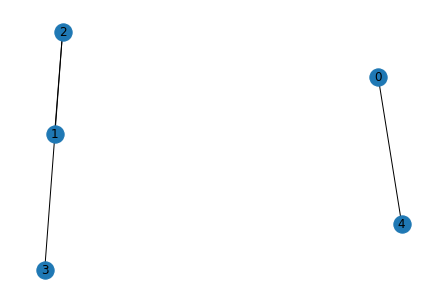

In [9]:
def show_graph(b):
    g = b.reshape((5,5)).cpu().numpy()
    graph = networkx.from_numpy_array(g)
    networkx.draw(graph, with_labels=True)
    plt.show()
show_graph(b)

Let's now examine the trajectory data for the first data point.

In [10]:
x_sample[idx].shape

torch.Size([5, 49, 4])

The shape of the data above specifies that each entry consists of 5 particles with trajectories given for 49 time steps.
Furthermore, each state in the trajectory is specified by a 4 dimensional vector.
In this case the state is a 2d position and 2d velocity pair specifying the position and velocity of each particle at each time step.
We examine the position and velocity of the first particle in the first trajectory for a couple of time steps.

In [11]:
x_sample[idx,0,0:2,:]

tensor([[-0.1272, -0.0987, -0.3305,  0.1197],
        [-0.1380, -0.0945, -0.3275,  0.1196]])

Next we define some hyperparameters.

In [12]:
dims=4
num_atoms=5
timesteps=49
lr=0.0005
temp=0.5
output_var=5e-5

_EPS = 1e-10

Recall that we mentioned above that the encoder of the model works on the fully connected graph in order to predict the interaction graph.
To pass messages over the fully connected graph, it is useful to define some relational masks specifying which vertices receive messages from which other ones.

In [13]:
def encode_onehot(labels):
    classes = set(labels)
    classes_dict = {c: np.identity(len(classes))[i, :] for i, c in
                    enumerate(classes)}
    labels_onehot = np.array(list(map(classes_dict.get, labels)),
                             dtype=np.int32)
    return labels_onehot

off_diag = np.ones([num_atoms, num_atoms]) - np.eye(num_atoms)

rel_rec = np.array(encode_onehot(np.where(off_diag)[0]), dtype=np.float32)
rel_send = np.array(encode_onehot(np.where(off_diag)[1]), dtype=np.float32)
rel_rec = torch.FloatTensor(rel_rec)
rel_send = torch.FloatTensor(rel_send)

We can convert edge features into node features and node features into edge features by passing messages over the fully connected graph using these masks.

In [14]:
print(rel_rec.t(), rel_rec.shape)

tensor([[1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
         1., 1.]]) torch.Size([20, 5])


For example to convert edge features for the 20 interactions into node features we can multiply the above matrix with the edge feature vector as 
```
torch.matmul(rel_rec.t(), x)
```
which collects the messages from all neighboring nodes for each vertex and adds the messages.

Next we define a simple MLP class to be used for the nonlinear feature transformations.

In [15]:
class MLP(nn.Module):
    """Two-layer fully-connected ELU net with batch norm."""

    def __init__(self, n_in, n_hid, n_out, do_prob=0.):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(n_in, n_hid)
        self.fc2 = nn.Linear(n_hid, n_out)
        self.bn = nn.BatchNorm1d(n_out)
        self.dropout_prob = do_prob

        self.init_weights()

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal(m.weight.data)
                m.bias.data.fill_(0.1)
            elif isinstance(m, nn.BatchNorm1d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def batch_norm(self, inputs):
        x = inputs.view(inputs.size(0) * inputs.size(1), -1)
        x = self.bn(x)
        return x.view(inputs.size(0), inputs.size(1), -1)

    def forward(self, inputs):
        # Input shape: [num_sims, num_things, num_features]
        x = F.elu(self.fc1(inputs))
        x = F.dropout(x, self.dropout_prob, training=self.training)
        x = F.elu(self.fc2(x))
        return self.batch_norm(x)

### Encoder

Next we specify the VAE encoder as a graph neural network.
For each particle we construct a single feature vector by using the entire trajectory information.
We include three graph neural network layers that convert the node features into edge features into node features and finally into edge features. 
The final edge features are then used to parameterize the edge probabilities for the graph sampling operation.

In [16]:

class MLPEncoder(nn.Module):
    def __init__(self, n_in, n_hid, n_out=2, do_prob=0.,):
        super(MLPEncoder, self).__init__()

        self.mlp1 = MLP(n_in, n_hid, n_hid, do_prob)
        self.mlp2 = MLP(n_hid * 2, n_hid, n_hid, do_prob)
        self.mlp3 = MLP(n_hid, n_hid, n_hid, do_prob)
        self.mlp4 = MLP(n_hid * 3, n_hid, n_hid, do_prob)
        
        self.fc_out = nn.Linear(n_hid, n_out)
        self.init_weights()

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal(m.weight.data)
                m.bias.data.fill_(0.1)

    def edge2node(self, x, rel_rec, rel_send):
        # NOTE: Assumes that we have the same graph across all samples.
        incoming = torch.matmul(rel_rec.t(), x)
        return incoming / incoming.size(1)

    def node2edge(self, x, rel_rec, rel_send):
        # NOTE: Assumes that we have the same graph across all samples.
        receivers = torch.matmul(rel_rec, x)
        senders = torch.matmul(rel_send, x)
        edges = torch.cat([senders, receivers], dim=2)
        return edges

    def forward(self, inputs, rel_rec, rel_send):
        # Input shape: [num_sims, num_atoms, num_timesteps, num_dims]
        x = inputs.view(inputs.size(0), inputs.size(1), -1)
        # New shape: [num_sims, num_atoms, num_timesteps*num_dims]

        x = self.mlp1(x)  # 2-layer ELU net per node

        x = self.node2edge(x, rel_rec, rel_send)
        x = self.mlp2(x)
        x_skip = x

        x = self.edge2node(x, rel_rec, rel_send)
        x = self.mlp3(x)
        x = self.node2edge(x, rel_rec, rel_send)
        x = torch.cat((x, x_skip), dim=2)  # Skip connection
        x = self.mlp4(x)

        return self.fc_out(x)

### Decoder 

In the decoder we take the initial state and attempt to predict the remaining trajectory.
To predict a single time step the function `single_step_forward` takes as input the current state and the proposed interaction graph.
From the states of the nodes as node features we produce edge features by passing messages over all neighbors and then zero out the messages corresponding to edges not present in the proposed graph.
The edge messages are then sent to the corresponding nodes after which we apply an MLP to compute the next prediction as a difference with the current state.
The process is then repeated for all timesteps.

In [17]:
class MLPDecoder(nn.Module):
    """MLP decoder module."""

    def __init__(self, n_in_node, edge_types, msg_hid, msg_out, n_hid,
                 do_prob=0.):
        super(MLPDecoder, self).__init__()

        self.msg_fc1 = (nn.Linear(2 * n_in_node, msg_hid))
        self.msg_fc2 = (nn.Linear(msg_hid, msg_out))
        self.msg_out_shape = msg_out

        self.out_fc1 = nn.Linear(n_in_node + msg_out, n_hid)
        self.out_fc2 = nn.Linear(n_hid, n_hid)
        self.out_fc3 = nn.Linear(n_hid, n_in_node)

        print('Using learned interaction net decoder.')

        self.dropout_prob = do_prob

    def single_step_forward(self, single_timestep_inputs, rel_rec, rel_send,
                            single_timestep_rel_type):

        # single_timestep_inputs has shape
        # [batch_size, num_timesteps, num_atoms, num_dims]

        # single_timestep_rel_type has shape:
        # [batch_size, num_timesteps, num_atoms*(num_atoms-1), num_edge_types]

        # Node2edge
        receivers = torch.matmul(rel_rec, single_timestep_inputs)
        senders = torch.matmul(rel_send, single_timestep_inputs)
        pre_msg = torch.cat([senders, receivers], dim=-1)

        msg = F.relu(self.msg_fc1(pre_msg))
        msg = F.dropout(msg, p=self.dropout_prob)
        msg = F.relu(self.msg_fc2(msg))
        msg = msg * single_timestep_rel_type[:, :, :, 1:2]

        # Aggregate all msgs to receiver
        agg_msgs = msg.transpose(-2, -1).matmul(rel_rec).transpose(-2, -1)
        agg_msgs = agg_msgs.contiguous()

        # Skip connection
        aug_inputs = torch.cat([single_timestep_inputs, agg_msgs], dim=-1)

        # Output MLP
        pred = F.dropout(F.relu(self.out_fc1(aug_inputs)), p=self.dropout_prob)
        pred = F.dropout(F.relu(self.out_fc2(pred)), p=self.dropout_prob)
        pred = self.out_fc3(pred)

        # Predict position/velocity difference
        return single_timestep_inputs + pred

    def forward(self, inputs, rel_type, rel_rec, rel_send, pred_steps=1):
        # NOTE: Assumes that we have the same graph across all samples.

        inputs = inputs.transpose(1, 2).contiguous()

        sizes = [rel_type.size(0), inputs.size(1), rel_type.size(1),
                 rel_type.size(2)]
        rel_type = rel_type.unsqueeze(1).expand(sizes)

        time_steps = inputs.size(1)
        assert (pred_steps <= time_steps)
        preds = []

        # initial step
        last_pred = inputs[:, 0:1, :, :]
        # NOTE: Assumes rel_type is constant (i.e. same across all time steps).
        curr_rel_type = rel_type[:, 0:1, :, :]

        # Run n prediction steps
        for step in range(0, pred_steps):
            last_pred = self.single_step_forward(last_pred, rel_rec, rel_send,
                                                 curr_rel_type)
            preds.append(last_pred)

        sizes = [preds[0].size(0), preds[0].size(1) * pred_steps,
                 preds[0].size(2), preds[0].size(3)]

        #output = Variable(torch.zeros(sizes))
        output = torch.zeros(sizes)
        if inputs.is_cuda:
            output = output.cuda()

        # Re-assemble correct timeline
        for i in range(len(preds)):
            output[:, i:i+1, :, :] = preds[i]

        pred_all = output[:, :(inputs.size(1) - 1), :, :]

        return pred_all.transpose(1, 2).contiguous()


Now we make a few helper arrays to specify the sending and receiving nodes in a message passing step. These simply correspond to the neighbors in a fully connected graph.

In [18]:

# Generate off-diagonal interaction graph
off_diag = np.ones([num_atoms, num_atoms]) - np.eye(num_atoms)

rel_rec = np.array(encode_onehot(np.where(off_diag)[0]), dtype=np.float32)
rel_send = np.array(encode_onehot(np.where(off_diag)[1]), dtype=np.float32)
rel_rec = torch.FloatTensor(rel_rec)
rel_send = torch.FloatTensor(rel_send)

In [19]:
#edge weights have dim 2
encoder = MLPEncoder(timesteps * dims, 256, 2)
decoder = MLPDecoder(n_in_node=dims,
                         edge_types=2,
                         msg_hid=256,
                         msg_out=256,
                         n_hid=256, )

Using learned interaction net decoder.


/home/apervez/anaconda3/envs/pytorch1.9_2/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  app.launch_new_instance()


In [20]:
encoder.cuda()
decoder.cuda()
rel_rec = rel_rec.cuda()
rel_send = rel_send.cuda()

In [21]:
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()),
                       lr=lr)
train_loader, valid_loader, test_loader, loc_max, loc_min, vel_max, vel_min = load_data(
    128, "_springs5")


### Discrete Sampling

We will sample graphs by selecting a subset of the fully connected graph using the weights output by the encoder by using Gumbel softmax.
We define the Gumbel softmax routines below as from the earlier tutorial.

In [22]:
def my_softmax(input, axis=1):
    trans_input = input.transpose(axis, 0).contiguous()
    soft_max_1d = F.softmax(trans_input)
    return soft_max_1d.transpose(axis, 0)

def sample_gumbel(shape, eps=1e-10):
    U = torch.rand(shape).float()
    return - torch.log(eps - torch.log(U + eps))

def gumbel_softmax_sample(logits, tau=1, eps=1e-10):
    gumbel_noise = sample_gumbel(logits.size(), eps=eps)
    if logits.is_cuda:
        gumbel_noise = gumbel_noise.cuda()
    y = logits + Variable(gumbel_noise)
    return my_softmax(y / tau, axis=-1)


def gumbel_softmax(logits, tau=1, hard=False, eps=1e-10):
    y_soft = gumbel_softmax_sample(logits, tau=tau, eps=eps)
    if hard:
        shape = logits.size()
        _, k = y_soft.data.max(-1)
        y_hard = torch.zeros(*shape)
        if y_soft.is_cuda:
            y_hard = y_hard.cuda()
        y_hard = y_hard.zero_().scatter_(-1, k.view(shape[:-1] + (1,)), 1.0)
        y = Variable(y_hard - y_soft.data) + y_soft
    else:
        y = y_soft
    return y


Next we define some helper functions for computing accuracies, prediction loss and KL divergence.

In [23]:

def kl_categorical_uniform(preds, num_atoms, num_edge_types, add_const=False,
                           eps=1e-16):
    kl_div = preds * torch.log(preds + eps)
    if add_const:
        const = np.log(num_edge_types)
        kl_div += const
    return kl_div.sum() / (num_atoms * preds.size(0))


def nll_gaussian(preds, target, variance, add_const=False):
    neg_log_p = ((preds - target) ** 2 / (2 * variance))
    if add_const:
        const = 0.5 * np.log(2 * np.pi * variance)
        neg_log_p += const
    return neg_log_p.sum() / (target.size(0) * target.size(1))

def edge_accuracy(preds, target):
    _, preds = preds.max(-1)
    correct = preds.float().data.eq(
        target.float().data.view_as(preds)).cpu().sum()
    return np.float(correct) / (target.size(0) * target.size(1))



We can now train the model.
This runs the encoder to get the latent graph parameters and samples the edges using the `gumbel_softmax` function to get a latent graph which is then passed to the decoder.
We use the uniform categorical prior to compute the KL divergence for the VAE loss and a Gaussian likelihood loss with a fixed various for the predictions.

In [24]:
def train(epoch, best_val_loss):
    t = time.time()
    nll_train = []
    acc_train = []
    kl_train = []
    mse_train = []

    encoder.train()
    decoder.train()
    #scheduler.step()
    for batch_idx, (data, relations) in enumerate(train_loader):

        #if args.cuda:
        data, relations = data.cuda(), relations.cuda()
        #data, relations = Variable(data), Variable(relations)

        optimizer.zero_grad()

        logits = encoder(data, rel_rec, rel_send)
        edges = gumbel_softmax(logits, tau=temp, hard=False)
        prob = my_softmax(logits, -1)

        output = decoder(data, edges, rel_rec, rel_send, timesteps)

        target = data[:, :, 1:, :]

        loss_nll = nll_gaussian(output, target, output_var)

        loss_kl = kl_categorical_uniform(prob, num_atoms, 2)

        loss = loss_nll + loss_kl

        acc = edge_accuracy(logits, relations)
        acc_train.append(acc)

        loss.backward()
        optimizer.step()

        mse_train.append(F.mse_loss(output, target).item())
        nll_train.append(loss_nll.item())
        kl_train.append(loss_kl.item())

    nll_val = []
    acc_val = []
    kl_val = []
    mse_val = []

    encoder.eval()
    decoder.eval()
    for batch_idx, (data, relations) in enumerate(valid_loader):
        #if args.cuda:
        data, relations = data.cuda(), relations.cuda()

        logits = encoder(data, rel_rec, rel_send)
        edges = gumbel_softmax(logits, tau=temp, hard=True)
        prob = my_softmax(logits, -1)

        # validation output uses teacher forcing
        output = decoder(data, edges, rel_rec, rel_send, timesteps)

        target = data[:, :, 1:, :]
        loss_nll = nll_gaussian(output, target, output_var)

        loss_kl = kl_categorical_uniform(prob, num_atoms, 2)

        acc = edge_accuracy(logits, relations)
        acc_val.append(acc)

        mse_val.append(F.mse_loss(output, target).item())
        nll_val.append(loss_nll.item())
        kl_val.append(loss_kl.item())

    print('Epoch: {:04d}'.format(epoch),
          'nll_train: {:.10f}'.format(np.mean(nll_train)),
          'kl_train: {:.10f}'.format(np.mean(kl_train)),
          'mse_train: {:.10f}'.format(np.mean(mse_train)),
          'acc_train: {:.10f}'.format(np.mean(acc_train)),
          'nll_val: {:.10f}'.format(np.mean(nll_val)),
          'kl_val: {:.10f}'.format(np.mean(kl_val)),
          'mse_val: {:.10f}'.format(np.mean(mse_val)),
          'acc_val: {:.10f}'.format(np.mean(acc_val)),
          'time: {:.4f}s'.format(time.time() - t))
    return np.mean(nll_val)



In [ ]:
t_total = time.time()
best_val_loss = np.inf
best_epoch = 0
for epoch in range(10):
    val_loss = train(epoch, best_val_loss)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch


/home/apervez/anaconda3/envs/pytorch1.9_2/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch: 0000 nll_train: 82207.3378531610 kl_train: -0.4316625203 mse_train: 0.0428163237 acc_train: 0.5102473625 nll_val: 13553.7608163568 kl_val: -0.5440562605 mse_val: 0.0070592507 acc_val: 0.5207624604 time: 39.0780s
Epoch: 0001 nll_train: 10482.0866405750 kl_train: -0.8068965521 mse_train: 0.0054594203 acc_train: 0.5672370524 nll_val: 9608.4652764043 kl_val: -0.9848571722 mse_val: 0.0050044091 acc_val: 0.6150959256 time: 38.8682s
Epoch: 0002 nll_train: 7622.5237534467 kl_train: -0.9681852530 mse_train: 0.0039700646 acc_train: 0.6575051950 nll_val: 7999.2846617880 kl_val: -0.9407296845 mse_val: 0.0041662942 acc_val: 0.6889833861 time: 38.9219s
Epoch: 0003 nll_train: 6435.7686271180 kl_train: -0.8848858903 mse_train: 0.0033519629 acc_train: 0.7282261029 nll_val: 6645.1351859177 kl_val: -0.8726646719 mse_val: 0.0034610081 acc_val: 0.7700009889 time: 38.9155s
Epoch: 0004 nll_train: 5131.3655265945 kl_train: -0.7572590768 mse_train: 0.0026725863 acc_train: 0.8130400815 nll_val: 4324.9007

### Visualizing Discovered Graphs
We can now visualize the actual and predicted interaction graphs for some examples.

In [ ]:
data,relations = next(iter(valid_loader))
data=data.cuda()
relations=relations.cuda()

In [ ]:
logits = encoder(data, rel_rec, rel_send)
_, rel = logits.max(-1)

In [ ]:
print(rel[0])
print(relations[0])

In [ ]:
for i in range(5):
    g_act = list_to_adj(relations[i])
    g_pred = list_to_adj(rel[i])

    print("Original")
    show_graph(g_act)
    print("Predicted")
    show_graph(g_pred)

## References

[Neural Relational Inference for Interacting Systems](https://arxiv.org/abs/1802.04687)